In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mdtraj as md
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import ScalarFormatter
from PIL import Image
import pandas as pd
import sys
!git clone https://github.com/fpesceKU/BLOCKING.git
sys.path.append('BLOCKING/')
from main import BlockAnalysis


plt.rc('font', family='Arial')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 9 
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['xtick.top'] = True      
plt.rcParams['ytick.right'] = True   


fatal: destination path 'BLOCKING' already exists and is not an empty directory.


# Scannning parameters of bond etc

In [3]:
def get_bkbk_bond(t):
    n = t.topology.n_atoms
    pairs=[]
    for i in range(0,n-2,2):
        pairs.append([i,i+2])
    return md.compute_distances(t, pairs)

def get_bkbs_bond(t):
    n = t.topology.n_atoms
    pairs=[]
    for i in range(0,n-1,2):
        pairs.append([i,i+1])
    return md.compute_distances(t, pairs)

def get_bsbs_bond(t):
    n = t.topology.n_atoms
    pairs=[]
    for i in range(1,n-2,2):
        pairs.append([i,i+2])
    return md.compute_distances(t, pairs)

def get_dihedral(t):
    n = t.topology.n_atoms
    pairs = []
    for i in range(0,n-3,2):
        pairs.append([i+1, i, i+2, i+3])
    return  md.compute_dihedrals(t, pairs)

def get_angle(t):
    n = t.topology.n_atoms
    pairs = []
    for i in range(0,n-4,2):
        pairs.append([i, i+2, i+4])
    return  md.compute_angles(t, pairs)

def many_body_analysis(_name,key,a=10,u=10,p=0,ion=100):
    dir_ = _name
    T,skip = 293, 500
    #key= _name+"_p"+str(p)+"a"+str(u)+"u"+str(u)+"_"+str(ion)
    t = md.load("{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
                          top="{0}/{1}/{2}/top.pdb".format(key,_name,T))
    bkbk = get_bkbk_bond(t)
    bkbs = get_bkbs_bond(t)
    ang = get_angle(t) 
    di = get_dihedral(t)
    bsbs = get_bsbs_bond(t)
  
    return bkbk,bkbs,ang,di,bsbs

def torsion_pairs(top): # use 1,2,3,4, zero based
    pairs = []
    pairs.append([top.select("name N1 and resid 1")[0],
                             top.select("name P and resid 1")[0],
                             top.select("name P and resid 2")[0],
                             top.select("name N9 and resid 2")[0]])
    pairs.append([top.select("name N9 and resid 2")[0],
                             top.select("name P and resid 2")[0],
                             top.select("name P and resid 3")[0],
                             top.select("name N9 and resid 3")[0]])
    pairs.append([top.select("name N9 and resid 3")[0],
                             top.select("name P and resid 3")[0],
                             top.select("name P and resid 4")[0],
                             top.select("name N1 and resid 4")[0]])             
    #pairs.append([top.select("name N1 and resid 4")[0],
     #                        top.select("name P and resid 4")[0],
     #                        top.select("name P and resid 5")[0],
      #                       top.select("name N1 and resid 5")[0]])
    return np.array(pairs)

def bs_bs_pairs(top): # use 1,2,3,4, zero based
    pairs = []
    pairs.append([top.select("name N1 and resid 1")[0],
                             top.select("name N9 and resid 2")[0]])
    pairs.append([top.select("name N9 and resid 2")[0],
                             top.select("name N9 and resid 3")[0]])
    pairs.append([top.select("name N9 and resid 3")[0],
                             top.select("name N1 and resid 4")[0]])             
    #pairs.append([top.select("name N1 and resid 4")[0],
    #                         top.select("name N1 and resid 5")[0]])
    return np.array(pairs)
    

def bk_bk_pairs(top):
    p_ind = top.select("name P")
    pairs = []
    #for i in range(len(p_ind)-1):
    for i in range(len(p_ind)-2): # use 1,2,3,4, zero based
        pairs.append((p_ind[i], p_ind[i+1]))
    return np.array(pairs)

def bk_angle_pairs(top):
    p_ind = top.select("name P")
    pairs = []
    #for i in range(len(p_ind)-2):
    for i in range(len(p_ind)-3): # use residues 1,2,3, zero based
        pairs.append((p_ind[i], p_ind[i+1],p_ind[i+2]))
    return np.array(pairs)

def bk_bs_pairs(top): # use residues 1,2,3,4 , zero based
    pairs = []
    pairs.append([top.select("name P and resid 1")[0], top.select("name N1 and resid 1")[0]])
    pairs.append([top.select("name P and resid 2")[0], top.select("name N9 and resid 2")[0]])
    pairs.append([top.select("name P and resid 3")[0], top.select("name N9 and resid 3")[0]])
    pairs.append([top.select("name P and resid 4")[0], top.select("name N1 and resid 4")[0]])
    #pairs.append([top.select("name P and resid 5")[0], top.select("name N1 and resid 5")[0]]) terminal included
    return np.array(pairs)
    

# Scanning lamda parameter

In [4]:
def read_exp(_name="polyU30",fn='./data/view1/exp/'):
    f = fn+"pollack2020.csv"
    df = pd.read_csv(f)
    exp = df[df['name']==_name]
    return exp

def calcRg(t,masses):
    # calculate the center of mass
    cm = np.sum(t.xyz*masses[np.newaxis,:,np.newaxis],axis=1)/masses.sum()
    # calculate residue-cm distances
    si = np.linalg.norm(t.xyz - cm[:,np.newaxis,:],axis=2)
    # calculate rg
    rgarray = np.sqrt(np.sum(si**2*masses,axis=1)/masses.sum())
    return rgarray


def read_sim(_name,_p,_a,_u,skip=500): #100ps*500=50 ns
    T=293
    df = []
    for i in ions:
        key=_name+"_p"+str(_p)+"a"+str(_a)+"u"+str(_u)+"_"+str(i)
        trj = md.load(dir_+"/{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
                      top=dir_+"/{0}/{1}/{2}/top.pdb".format(key,_name,T))
        rg = calcRg(trj, masses=get_mass(_name))[skip:]
        mean,std = np.mean(rg),np.std(rg)
        df.append([i,mean,std])
    df = pd.DataFrame(df, columns=["conc","mean", "std"])
    return df

def get_mass(_name,n=30,mp=194.1,ma=134.1,mu=111.1,mr=126.3):
    mass = []
    if _name=="polyA30":
        for i in range(n):
            mass.append(mp)
            mass.append(ma)
    elif _name=="polyU30":
        for i in range(n):
            mass.append(mp)
            mass.append(mu)
    elif _name=="polyU":
        for i in range(n):
            mass.append(mp)
            mass.append(mu)
    elif _name=="polyR30":
        for i in range(n):
            mass.append(mp)
            mass.append(mu)
    return np.array(mass)


def get_rgs_exp(name,ions):
        exp_rg = read_exp(_name=name).set_index('conc')
        return exp_rg.loc[ions,'mean']/10
    
    
def get_rgs_std(name,ions):
        exp_rg = read_exp(_name=name).set_index('conc')
        return exp_rg.loc[ions,'std']/10
    
    
def get_rg_sim(p,u,ions,_name='polyU30'):
    dir_ = './grid_single_chain_293/'+_name
    T,skip,unit = 293,500,1
    rgs = []
    for ion in ions:
        key=_name+"_p"+str(p)+"a"+str(u)+"u"+str(u)+"_"+str(ion)
        trj = md.load(dir_+"/{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
                  top=dir_+"/{0}/{1}/{2}/top.pdb".format(key,_name,T))
        rg = calcRg(trj, masses=get_mass(_name))[skip:]
        N = 1500
        if len(rg)<1500:
            print("p:{:d}, a{:d}, u{:d}, Ion{:d}".format(p,u,u,ion))
        rgs.append(np.mean(rg))
    return np.array(rgs)*unit


def get_ci_square(p,u,_name,exp_name,ions):
    dir_ = './grid_single_chain_293/'+_name
    T,skip,unit = 293, 500,10
    sim_mean = []
    for ion in ions:
        key=_name+"_p"+str(p)+"a"+str(u)+"u"+str(u)+"_"+str(ion)
        trj = md.load(dir_+"/{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
                  top=dir_+"/{0}/{1}/{2}/top.pdb".format(key,_name,T))
        rg = calcRg(trj, masses=get_mass(_name))[skip:]
        N = 1500
        if len(rg)<1500:
            print("p:{:d}, a{:d}, u{:d}, Ion{:d}".format(p,u,u,ion))
        sim_mean.append(np.mean(rg))
    sim_mean = np.array(sim_mean)*unit
    exp_rg = read_exp(_name=exp_name).set_index('conc')
    exp_mean = exp_rg.loc[ions,'mean'].to_numpy()
    exp_std = exp_rg.loc[ions,'std'].to_numpy()
    m = len(exp_mean)
    n = 2
    chi_square = np.sum( np.square(sim_mean-exp_mean)/np.square(exp_std) ) / (m-n)
    return chi_square

def get_ci_square_vect(p,u,_name,exp_name,ions):
    dir_ = './grid_single_chain_293/'+_name
    T,skip,unit = 293, 500,10
    sim_mean = []
    for ion in ions:
        key=_name+"_p"+str(p)+"a"+str(u)+"u"+str(u)+"_"+str(ion)
        trj = md.load(dir_+"/{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
                  top=dir_+"/{0}/{1}/{2}/top.pdb".format(key,_name,T))
        rg = calcRg(trj, masses=get_mass(_name))[skip:]
        N = 1500
        if len(rg)<1500:
            print("p:{:d}, a{:d}, u{:d}, Ion{:d}".format(p,u,u,ion))
        sim_mean.append(np.mean(rg))
    sim_mean = np.array(sim_mean)*unit
    exp_rg = read_exp(_name=exp_name).set_index('conc')
    exp_mean = exp_rg.loc[ions,'mean'].to_numpy()
    exp_std = exp_rg.loc[ions,'std'].to_numpy()
    chi_square = np.square(sim_mean-exp_mean)/np.square(exp_std)
    return chi_square


def get_ci_square_polyA30polyU30(p,u,_name):
    exp_name='polyU30'
    ions = [20,100,200,400,600]
    chi1 = get_ci_square_vect(p,u,_name,exp_name,ions)
    exp_name='polyA30'
    ions = [20,200,400,600]
    chi2 = get_ci_square_vect(p,u,_name,exp_name,ions)
    chi = np.concatenate([chi1,chi2])
    m = len(chi)
    n = 2
    chi = np.sum(chi)/(m-n)
    return chi
  
    
def plot_grid(name,exp_name,ions):
    grids = lplb_list
    data = []
    for grid in grids:
        [x,y] =  grid
        z = get_ci_square(x,y,name,exp_name,ions)
        data.append([x,y,z])
    data = np.array(data)
    n = 100
    x,y,chi = data[:,0]/n,data[:,1]/n,data[:,2] 
    return x,y,chi 


def plot_grid_polyA30polyU30(name):
    grids = lplb_list
    data = []
    for grid in grids:
        [x,y] =  grid
        z =  get_ci_square_polyA30polyU30(x,y,name)
        data.append([x,y,z])
    data = np.array(data)
    n = 100
    x,y,chi = data[:,0]/n,data[:,1]/n,data[:,2] 
    return x,y,chi 

def get_blocking_error(p,u,ions,_name='polyU30'):
    dir_ = './grid_single_chain_293/'+_name
    T,skip,unit = 293,500,1
    data = []
    for ion in ions:
        key=_name+"_p"+str(p)+"a"+str(u)+"u"+str(u)+"_"+str(ion)
        trj = md.load(dir_+"/{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
                  top=dir_+"/{0}/{1}/{2}/top.pdb".format(key,_name,T))
        rg = calcRg(trj, masses=get_mass(_name))[skip:]
        N = 1500
        if len(rg)<1500:
            print("p:{:d}, a{:d}, u{:d}, Ion{:d}".format(p,u,u,ion))
        block = BlockAnalysis(rg)    
        block.SEM()
        block_error =  block.sem 
        data.append(block.sem*unit)           
    return np.array(data)

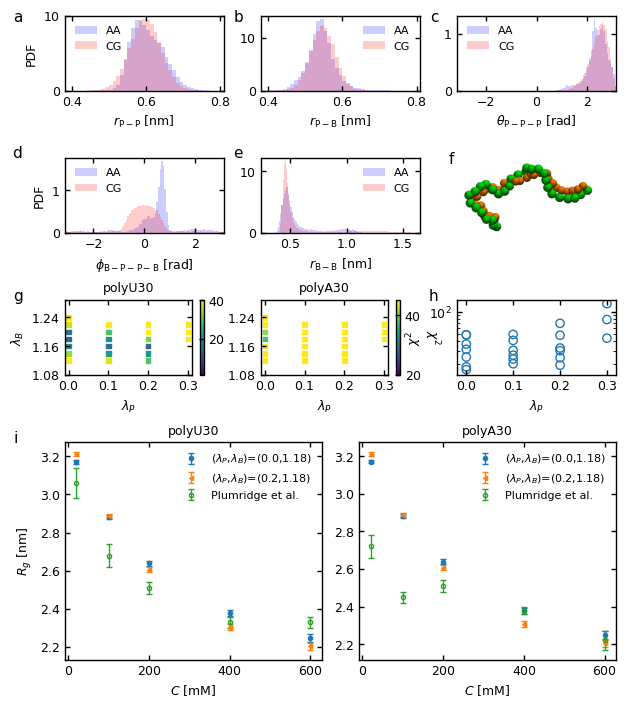

In [8]:
fig = plt.figure(figsize=(6.2,7))
ax1 = plt.subplot2grid( (5,6), (0,0), rowspan=1, colspan=2 )
ax2 = plt.subplot2grid( (5,6), (0,2), rowspan=1, colspan=2 )
ax3 = plt.subplot2grid( (5,6), (0,4), rowspan=1, colspan=2 )
ax4 = plt.subplot2grid( (5,6), (1,0), rowspan=1, colspan=2 )
ax5 = plt.subplot2grid( (5,6), (1,2), rowspan=1, colspan=2 )
ax6 = plt.subplot2grid( (5,6), (1,4), rowspan=1, colspan=2 )

cmap = plt.get_cmap("tab10")
"""

"""

data = np.load('./data/view1/p-p_dist.npy') 
bins = np.arange(0.4,0.8,0.01)
ax1.hist(data.reshape(-1), bins=bins, density=True, alpha=0.2,label="AA",color="b")

data = np.load('./data/view1/p-b_dist.npy')
bins = np.arange(0.4,0.8,0.01)
ax2.hist(data.reshape(-1), bins=bins, density=True, alpha=0.2,label="AA",color="b")

data = np.load('./data/view1/p-p-p_ang.npy')
bins = np.linspace(-np.pi,np.pi,100)
ax3.hist(data.reshape(-1), bins=bins, density=True, alpha=0.2, label="AA",color="b")

data = np.load('./data/view1/b-p-p-b_dhi.npy')
bins = np.linspace(-np.pi,np.pi,100)
ax4.hist(data.reshape(-1), bins=bins, density=True, alpha=0.2, label="AA",color="b")

data = np.load('./data/view1/b-b_dist.npy')
bins = np.arange(0.3,1.6,0.01)
ax5.hist(data.reshape(-1), bins=bins, density=True, alpha=0.2, label="AA",color="b")


bkbk = np.load('./data/view1/p-p_dist_cg.npy')
bkbs = np.load('./data/view1/p-b_dist_cg.npy')
ang = np.load('./data/view1/p-p-p_ang_cg.npy')
di = np.load('./data/view1/b-p-p-b_dhi_cg.npy')
bsbs = np.load('./data/view1/b-b_dist_cg.npy')

bins = np.arange(0.4,0.8,0.01)
ax1.hist(bkbk.reshape(-1), bins=bins, density=True, alpha=0.2, color="r",label="CG")

bins = np.arange(0.4,0.8,0.01)
ax2.hist(bkbs.reshape(-1), bins=bins, density=True, alpha=0.2, color="r",label="CG")

bins = np.linspace(-np.pi,np.pi,100)
ax3.hist(ang.reshape(-1), bins=bins, density=True, alpha=0.2, color="r",label="CG")

di = di.reshape(-1)
bins = np.linspace(-np.pi,np.pi,100)
ax4.hist(di.reshape(-1), bins=bins, density=True, alpha=0.2, color="r",label="CG")

bins = np.arange(0.3,1.6,0.01)
ax5.hist(bsbs.reshape(-1), bins=bins, density=True, alpha=0.2, color="r",label="CG")

ax6.axis('off')
ax6 = fig.add_axes((0.74,0.64,0.22,0.18))
img = np.asarray(Image.open("./data/view1/single-chain.png"))
imgplot = ax6.imshow(img)
ax6.axis('off')

ax1.set_xlabel("$r_{\mathrm{P}-\mathrm{P}}$ [nm]")
ax1.set_ylabel("PDF")
ax1.legend(frameon=False,fontsize=8)
ax2.set_xlabel("$r_{\mathrm{P}-\mathrm{B}}$ [nm]")
ax2.legend(frameon=False,fontsize=8)

ax3.set_xlabel("$\\theta_{\mathrm{P}-\mathrm{P}-\mathrm{P}}$ [rad]")
ax3.legend(frameon=False,fontsize=8)
ax3.set_xlim([-np.pi,np.pi])

ax4.set_xlabel("$\phi_{\mathrm{B}-\mathrm{P}-\mathrm{P}-\mathrm{B}}$ [rad]")
ax4.legend(frameon=False,fontsize=8)
ax4.set_xlim([-np.pi,np.pi])
ax4.set_ylabel("PDF")

ax5.set_xlabel("Base$-$Base distance [nm]")
ax5.set_xlabel("$r_{\mathrm{B}-\mathrm{B}}$ [nm]")
ax5.legend(frameon=False,fontsize=8)


"""
lambda scanning
"""

dir_="./data/view1/"
ax7 = plt.subplot2grid( (5,6), (2,0), rowspan=1, colspan=2 )
ax8 = plt.subplot2grid( (5,6), (2,2), rowspan=1, colspan=2 )
ax9 = plt.subplot2grid( (5,6), (2,4), rowspan=1, colspan=2 )
ax10 = plt.subplot2grid( (5,6), (3,0), rowspan=2, colspan=3 )
ax11 = plt.subplot2grid( (5,6), (3,3), rowspan=2, colspan=3 )

name,ions = 'polyU30',[20,100,200,400,600]
data = np.load(dir_+'{:s}_chi.npy'.format(name))
x,y,chi = data[0,:],data[1,:],data[2,:]
plot=ax7.scatter(x,y,c=chi,marker='s', s=10,vmin=1, vmax=40)
cbar= fig.colorbar(plot,ax=ax7)
ax7.set_ylabel('$\lambda_B$')
ax7.set_xlabel('$\lambda_P$')
ax7.set_title('{:s}'.format(name),fontsize=9)
ax7.set_yticks(np.arange(1.08,1.3,0.08),rotation=0)             
ax7.set_xticks(np.arange(-0,0.4,0.1),rotation=45)
ax7.set_xlim([-0.01,0.31])

"""
"""
name,ions = 'polyA30',[20,200,400,600] 
data = np.load(dir_+'{:s}_chi.npy'.format(name))
x,y,chi = data[0,:],data[1,:],data[2,:]
plot=ax8.scatter(x,y,c=chi,marker='s', s=10,vmin=20, vmax=45)
cbar= fig.colorbar(plot,ax=ax8)
cbar.set_label('$\chi^2$', rotation=270,labelpad=15)
ax8.set_xlabel('$\lambda_P$')
ax8.set_title('{:s}'.format(name),fontsize=9)
ax8.set_yticks(np.arange(1.08,1.3,0.08),rotation=0)             
ax8.set_xticks(np.arange(-0,0.4,0.1),rotation=45)
ax8.set_xlim([-0.01,0.31])

"""
"""
data = np.load(dir_+'polyA30polyU30_chi.npy')
x,y,chi = data[0,:],data[1,:],data[2,:]
ax9.scatter(x,chi,facecolor="none", edgecolors=cmap(0))
ax9.set_yscale('log')
ax9.set_ylabel('$\chi^2$')
ax9.set_xlabel('$\lambda_P$')
ax9.set_xlim([-0.02,0.32])
#ax9.legend(frameon=False)

"""
"""
p=0
a=118
name,ions = 'polyR30',[20,100,200,400,600]
rg_p0n118 = np.load("./data/view1/rg_p0n118.npy")
mean,std = rg_p0n118[0], rg_p0n118[1]
ax10.errorbar(ions,mean,yerr=std,label='($\lambda_P$,$\lambda_B$)=({:s},{:s})'.format(str(p/100)[:4],str(a/100)[:4])
             ,marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)
ax11.errorbar(ions,mean,yerr=std,label='($\lambda_P$,$\lambda_B$)=({:s},{:s})'.format(str(p/100)[:4],str(a/100)[:4])
             ,marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)

p=20
n=116
rg_p20n116 = np.load("./data/view1/rg_p20n116.npy")
mean,std = rg_p20n116[0], rg_p20n116[1]
ax10.errorbar(ions,mean,yerr=std,label='($\lambda_P$,$\lambda_B$)=({:s},{:s})'.format(str(p/100)[:4],str(a/100)[:4])
             ,marker='<', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)
ax11.errorbar(ions,mean,yerr=std,label='($\lambda_P$,$\lambda_B$)=({:s},{:s})'.format(str(p/100)[:4],str(a/100)[:4])
             ,marker='<', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)

name,ions = 'polyU30',[20,100,200,400,600]
exp = get_rgs_exp(name,ions)
std = get_rgs_std(name,ions)
ax10.errorbar(ions,exp,yerr=std,label='Plumridge et al.',marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1,markerfacecolor="none")
ax10.set_title(name,fontsize=9)
ax10.set_xlabel('$C$ [mM]')
ax10.set_ylabel('$R_g$ [nm]')
ax10.legend(fontsize=8,frameon=False)

name,ions = 'polyA30',[20,100,200,400,600]
exp = get_rgs_exp(name,ions)
std = get_rgs_std(name,ions)
ax11.errorbar(ions,exp,yerr=std,label='Plumridge et al.',marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1,markerfacecolor="none")
ax11.set_title(name,fontsize=9)
ax11.set_xlabel('$C$ [mM]')
ax11.legend(fontsize=8,frameon=False)

ax1.text(-0.32,0.92,"a",transform=ax1.transAxes,size=11) #ax1.text(0.28,11,"a",size=11)
ax2.text(-0.17,0.92,"b",transform=ax2.transAxes,size=11)#text(0.28,15,"b",size=11)
ax3.text(-0.17,0.92,"c",transform=ax3.transAxes,size=11)#text(-4.5,1.5,"c",size=11)
ax4.text(-0.33,1,"d",transform=ax4.transAxes,size=11)#.text(-4.5,2,"d",size=11)
ax5.text(-0.17,1,"e",transform=ax5.transAxes,size=11)#.text(-.1,13,"e",size=11)
ax6.text(-0.09,0.96,"f",transform=ax6.transAxes,size=11)#ax6.text(0,3,"f",size=11)
ax7.text(-0.4,1,"g",transform=ax7.transAxes,size=11)
ax9.text(-0.18,1,"h",transform=ax9.transAxes,size=11)
ax10.text(-0.2,1,"i",transform=ax10.transAxes,size=11)

plt.subplots_adjust(wspace=0.6, hspace=0.9, left=0.1, right=0.99, bottom=0.07, top=0.99)
plt.savefig("figure2.pdf",dpi=300)

# Fig S1 for many-body interaction

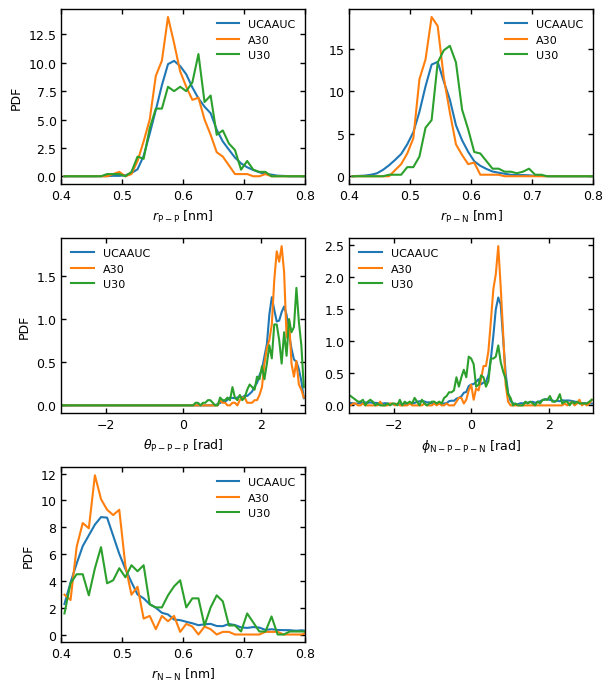

In [12]:
fig = plt.figure(figsize=(6.2,7))

ax1 = plt.subplot2grid( (3,2), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (3,2), (0,1), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (3,2), (1,0), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (3,2), (1,1), rowspan=1, colspan=1 )
ax5 = plt.subplot2grid( (3,2), (2,0), rowspan=1, colspan=1 )

bins = np.arange(0.4,0.82,0.01)
for name in ["UCAAUC","rA30","rU30"]:
    data = np.load('./all-atom/{:s}_bond_pp.npy'.format(name)).reshape(-1)
    data,_ = np.histogram(data, bins=bins,density=True)
    xs = 0.5*(bins[1:]+bins[:-1])
    if name in ["rA30","rU30"]:
        name = name[1:]
    ax1.plot(xs,data,label=name)

bins = np.arange(0.4,0.82,0.01)
for name in ["UCAAUC","rA30","rU30"]:
    data = np.load('all-atom/{:s}_bond_pbase.npy'.format(name)).reshape(-1)
    data,_ = np.histogram(data, bins=bins,density=True)
    xs = 0.5*(bins[1:]+bins[:-1])
    if name in ["rA30","rU30"]:
        name = name[1:]
    ax2.plot(xs,data,label=name)

bins = np.linspace(-np.pi,np.pi,100)
for name in ["UCAAUC","rA30","rU30"]:
    data = np.load('all-atom/{:s}_angle_ppp.npy'.format(name)).reshape(-1)
    data,_ = np.histogram(data, bins=bins,density=True)
    xs = 0.5*(bins[1:]+bins[:-1])
    if name in ["rA30","rU30"]:
        name = name[1:]
    ax3.plot(xs,data,label=name)

bins = np.linspace(-np.pi,np.pi,100)
for name in ["UCAAUC","rA30","rU30"]:
    data = np.load('all-atom/{:s}_dihedral_baseppbase.npy'.format(name)).reshape(-1)
    data,_ = np.histogram(data, bins=bins,density=True)
    xs = 0.5*(bins[1:]+bins[:-1])
    if name in ["rA30","rU30"]:
        name = name[1:]
    ax4.plot(xs,data,label=name)

bins = np.arange(0.4,0.82,0.01)
for name in ["UCAAUC","rA30","rU30"]:
    data = np.load('all-atom/{:s}_bond_basebase.npy'.format(name)).reshape(-1)
    data,_ = np.histogram(data, bins=bins,density=True)
    xs = 0.5*(bins[1:]+bins[:-1])
    if name in ["rA30","rU30"]:
        name = name[1:]
    ax5.plot(xs,data,label=name)


##########
# graphics    #
##########
#ax1.set_xlabel("P$-$P distance [nm]")
ax1.set_xlabel("$r_{\mathrm{P}-\mathrm{P}}$ [nm]")
ax1.set_ylabel("PDF")
ax1.legend(frameon=False,fontsize=8)
ax1.set_xlim([0.4,0.8])

ax2.set_xlabel("P$-$Base distance [nm]")
ax2.set_xlabel("$r_{\mathrm{P}-\mathrm{N}}$ [nm]")
ax2.legend(frameon=False,fontsize=8)
ax2.set_xlim([0.4,0.8])

ax3.set_xlabel("$\\theta_{\mathrm{P}-\mathrm{P}-\mathrm{P}}$ [rad]")
ax3.set_ylabel("PDF")
ax3.legend(frameon=False,fontsize=8)
ax3.set_xlim([-np.pi,np.pi])

ax4.set_xlabel("$\phi_{\mathrm{N}-\mathrm{P}-\mathrm{P}-\mathrm{N}}$ [rad]")
ax4.legend(frameon=False,fontsize=8)
ax4.set_xlim([-np.pi,np.pi])

ax5.set_xlabel("Base$-$Base distance [nm]")
ax5.set_xlabel("$r_{\mathrm{N}-\mathrm{N}}$ [nm]")
ax5.legend(frameon=False,fontsize=8)
ax5.set_ylabel("PDF")
ax5.set_xlim([0.4,0.8])

plt.tight_layout()
plt.savefig("manybody.pdf",dpi=300)


# Fig. S2 Flory exponent

In [8]:
def loaddata_fh_rg(ion):
    data = np.load("./data/view1/rg_{:d}mM.npy".format(ion))
    n_seq,rgs,errs = data[0],data[1],data[2]
    return n_seq,rgs,errs 

def loaddata_fh_nu(ion):
    data = np.load("./data/view1/flory_{:d}mM.npy".format(ion))
    r0,nu = data[0],data[1]
    return r0,nu

225 exponent 0.6694598428049532
525 exponent 0.5679231755205973


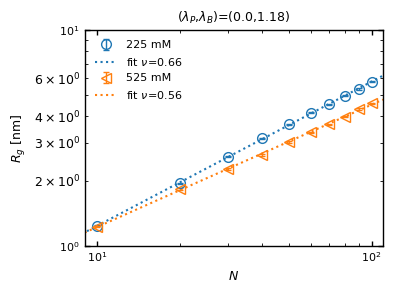

In [13]:
from matplotlib.ticker import LogFormatter

n_seq = [10,20,30,40,50,60,70,80,90,100]
[l1,l2] = [0,118]

# Use colormap for different ion values
cmap = plt.get_cmap("tab10")

# Create the plot
fig, ax = plt.subplots(figsize=(4, 3))  # Correctly initialize ax

# Loop over two ion values
markers = ["o","<"]
for ind, ion in enumerate([225, 525]):
    # Load data for radius of gyration (Rg) and errors
    n_seq, rgs, errs = loaddata_fh_rg(ion)
    
    # Plot the data with error bars
    ax.errorbar(n_seq, rgs, yerr=errs, label="{:d} mM".format(ion), marker=markers[ind], lw=0, ms=7, 
                elinewidth=1, capsize=2, capthick=1, markerfacecolor="none", color=cmap(ind))
    
    # Load data for r0 and nu (Flory-Huggins exponent)
    r0, nu = loaddata_fh_nu(ion)
    print(ion,"exponent",nu)
    # Use xs for further calculations or plotting if needed
    xs = np.arange(1, 111, 1)    
    ax.plot(xs,r0*(xs**nu), label="fit $\\nu$={:s}".format(str(nu)[:4]),linestyle="dotted")
        
    
# Add legend
hd, lb = ax.get_legend_handles_labels()
ax.legend([hd[2],hd[0],hd[3],hd[1]],[lb[2],lb[0],lb[3],lb[1]],fontsize=8, frameon=False)

# Set title and axis labels
# Assuming l1 and l2 are defined elsewhere in the script
ax.set_title('($\lambda_P$,$\lambda_B$)=({:s},{:s})'.format(str(l1 / 100)[:4], str(l2 / 100)[:4]),fontsize=9)

ax.set_xlabel("$N$",fontsize=9)
ax.set_xscale("log")
ax.set_ylim([10**0, 10**1])

ax.set_ylabel("$R_g$ [nm]",fontsize=9)
ax.set_yscale("log")
ax.set_xlim([9.0, 110])

ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)


# Adjust layout to ensure labels and titles fit well and save the figure
plt.tight_layout()
plt.savefig("flory_exponent.pdf", dpi=300)


# Fig 3  Second  virial coefficinent

/tmp/ipykernel_13512/3895687763.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=1, h_pad=0.1)


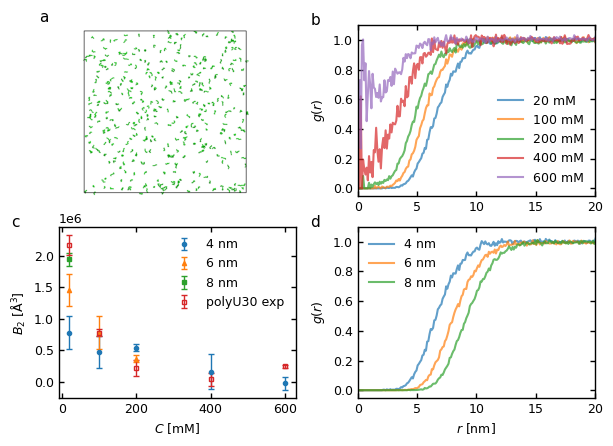

In [14]:
# RNA conc = 80  
fig = plt.figure(figsize=(6.2,4.5))
ax1 = plt.subplot2grid( (2,2), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (2,2), (0,1), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (2,2), (1,1), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (2,2), (1,0), rowspan=1, colspan=1 )


ax1.axis('off')
ax1 = fig.add_axes((0.07,0.55,0.4,0.4))
img = np.asarray(Image.open("./data/view1/400chain_L200.png"))
imgplot = ax1.imshow(img)
ax1.axis('off')

import pickle
with open('./data/view1/gr.pickle', mode='br') as fi:
    gr = pickle.load(fi)

    
name ='polyR30'
L = 405.03
ls = [ [0,118] ]
ions = [20,100,200,400,600]
rna_conc=10
dh_rc = 4
for ion in ions:
    data = gr["{:d}_{:d}_{:d}".format(rna_conc,ion,dh_rc)]
    x,y = data[0], data[1]
    ax2.plot(x, y, label='{:d} mM'.format(ion),alpha=0.7)
ax2.legend(frameon=False,fontsize=9)
#ax1.set_xlabel("$r$ [nm]")
ax2.set_ylabel("$g(r)$")
ax2.set_xlim([0,20]) #ax2.set_xlim([0,40])
ax2.set_ylim([-0.05,1.1])
#ax1.hlines(1,0,x[-1],linesty

"""
###################################
"""
ion = 20
for dh_rc in [4,6,8]:
    data = gr["{:d}_{:d}_{:d}".format(rna_conc,ion,dh_rc)]
    x,y = data[0], data[1]
    ax3.plot(x, y, label='{:d} nm'.format(dh_rc),alpha=0.7)    
ax3.legend(frameon=False,fontsize=9)
ax3.set_xlabel("$r$ [nm]")
ax3.set_ylabel("$g(r)$")
ax3.set_xlim([0,20])#ax3.set_xlim([0,40])
ax3.set_ylim([-0.05,1.1])

"""
###################################
"""
import pickle
with open('./data/view1/b2.pickle', mode='br') as fi:
    b2 = pickle.load(fi)


ions = [20,100,200,400,600]
rna_conc=10
dh_rc = 4
b2_rc = 20
data = []
for ion in ions:
    data.append( b2["{:d}_{:d}_{:d}_{:d}".format(rna_conc,ion,dh_rc,b2_rc)] )
data = np.array(data) 
mean, err = data[:,0],data[:,1]
ax4.errorbar(ions, mean, yerr=err, label='{:d} nm'.format(dh_rc)
             ,marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)

ions = [20,100,200]
rna_conc=10
dh_rc = 6
b2_rc = 20
data = []
for ion in ions:
    data.append( b2["{:d}_{:d}_{:d}_{:d}".format(rna_conc,ion,dh_rc,b2_rc)] )
data = np.array(data) 
mean, err = data[:,0],data[:,1]
ax4.errorbar(ions, mean, yerr=err, label='{:d} nm'.format(dh_rc)
             ,marker='^', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)

ions = [20]
rna_conc=10
dh_rc = 8
b2_rc = 15
data = []
for ion in ions:
    data.append( b2["{:d}_{:d}_{:d}_{:d}".format(rna_conc,ion,dh_rc,b2_rc)] )
data = np.array(data) 
mean, err = data[:,0],data[:,1]
ax4.errorbar(ions, mean, yerr=err, label='{:d} nm'.format(dh_rc)
             ,marker='s', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)


exp = pd.read_csv('./data/view1/exp/pollack2020.csv')
polyU30 = exp[exp['name']=='polyU30']
polyA30 = exp[exp['name']=='polyA30']
ax4.errorbar(polyU30['conc'],polyU30['b2_mean'], yerr=polyU30['b2_std'], label='polyU30 exp'
             ,marker='s', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1,markerfacecolor="none")
#ax3.errorbar(polyA30['conc'],polyA30['b2_mean'], yerr=polyA30['b2_std'], label='polyA30 exp'
#             ,marker='s', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1,markerfacecolor="none")

                  
ax4.legend(frameon=False,fontsize=9)
ax4.set_xlabel("$C$ [mM]")
ax4.set_ylabel("$B_{2}$ $[\mathrm{\AA^3}]$ ")

ax1.text(-0.2,1.0,"a",transform=ax1.transAxes,size=11) #ax1.text(0.28,11,"a",size=11)
ax2.text(-0.2,1,"b",transform=ax2.transAxes,size=11)#text(0.28,15,"b",size=11)
ax3.text(-0.2,1.0,"d",transform=ax3.transAxes,size=11)#text(-4.5,1.5,"c",size=11)
ax4.text(-0.2,1,"c",transform=ax4.transAxes,size=11)#text(-4.5,1.5,"c",size=11)

fig.tight_layout(w_pad=1, h_pad=0.1)
fig.savefig("figure3.pdf",dpi=300)

plt.show()